In [646]:
import pandas as pd
from sqlalchemy import create_engine
from pandas.tseries.holiday import USFederalHolidayCalendar
import numpy as np
import sqlite3
from sklearn.linear_model import LinearRegression
from scipy.stats import pearsonr
import plotly.graph_objs as go
from plotly.subplots import make_subplots
import matplotlib.pyplot as plt

In [647]:
#convert prices to numerical values
def convert_price(value):
    if isinstance(value, str) and 'k' in value.lower():
        # Remove 'k' and convert to float, then multiply by 1000
        new_price = float(value.lower().replace('k', '')) * 1000
        return new_price
    if isinstance(value, str) and 'M' in value.lower():
        # Remove 'M' and convert to float, then multiply by 1000000
        new_price = float(value.lower().replace('M', '')) * 1000000
        return new_price
        
    try:
        # Try to convert to float directly for numeric or string numeric values
        return float(value)
    except (ValueError, TypeError):
        # Return NaN for any invalid values
        return float('nan')

In [648]:
#Check for outliers (z-score > 3)
def remove_outliers(df, column, window, threshold):
        rolling_mean = df[column].rolling(window=window, center=True).mean()
        rolling_std = df[column].rolling(window=window, center=True).std()
        z_scores = (df[column] - rolling_mean) / rolling_std
        df[column] = np.where(abs(z_scores) > threshold, 
                              df[column].interpolate(method='linear'), 
                              df[column])
        return df

In [649]:
#Load Data
file = 'MSTR VS BITCOIN.xlsx'

In [650]:
#read excel data.
mstr_df = pd.read_excel(file, sheet_name='MSTR')
btc_df = pd.read_excel(file, sheet_name='BITCOIN')

In [651]:
#rename columns for consistency
mstr_df = mstr_df.rename(columns={'date': 'timestamp', 'lst px': 'price'})
btc_df = btc_df.rename(columns={'Date': 'timestamp', 'Close': 'price'})

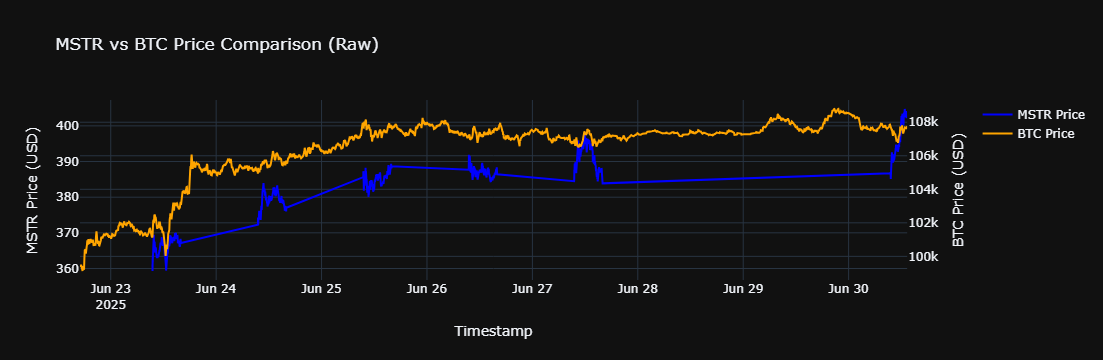

In [652]:
#ensure timestamps are datetime and standardise timestamps to UTC
mstr_df['Date'] = pd.to_datetime(mstr_df['timestamp'], utc=True)
btc_df['Date'] = pd.to_datetime(btc_df['timestamp'], utc=True)

btc_df_tmp = btc_df
btc_df_tmp['price'] = btc_df_tmp['price'].apply(convert_price)

fig = make_subplots(specs=[[{"secondary_y": True}]])
fig.add_trace(go.Scatter(x=mstr_df['timestamp'], y=mstr_df['price'], name='MSTR Price', line=dict(color='blue')),secondary_y=False)
fig.add_trace(go.Scatter(x=btc_df_tmp['timestamp'], y=btc_df_tmp['price'], name='BTC Price', line=dict(color='orange')),secondary_y=True)


fig.update_layout(title='MSTR vs BTC Price Comparison (Raw)', xaxis_title='Timestamp',yaxis_title='MSTR Price (USD)', yaxis2_title='BTC Price (USD)',template='plotly_dark')
fig.show()


In [653]:
#SQLite database
engine = create_engine('sqlite:///fourier_crypto_stock_data.db')

In [654]:
#make SQL tables
mstr_df.to_sql('mstr', engine, if_exists='replace', index=False)
btc_df.to_sql('btc', engine, if_exists='replace', index=False)


2262

In [655]:
#Clean and read data from SQL
mstr_df = pd.read_sql('SELECT timestamp, price, volume FROM mstr', engine)
btc_df = pd.read_sql('SELECT timestamp, price FROM btc', engine)

In [656]:
#Ensure timestamps are datetime for consistency
mstr_df['timestamp'] = pd.to_datetime(mstr_df['timestamp'], utc = True)
btc_df['timestamp'] = pd.to_datetime(btc_df['timestamp'], utc = True)

In [657]:
#filter MSTR to NASDAQ trading hours (9:30 AM - 4:00 PM ET, weekdays)
mstr_df = mstr_df[(mstr_df['timestamp'].dt.time >= pd.Timestamp('09:30:00').time()) &
                  (mstr_df['timestamp'].dt.time <= pd.Timestamp('16:00:00').time()) &
                  (mstr_df['timestamp'].dt.weekday < 5)]

In [658]:
#Exclude US holidays
cal = USFederalHolidayCalendar()
holidays = cal.holidays(start=mstr_df['timestamp'].min(), end=mstr_df['timestamp'].max())
mstr_df = mstr_df[~mstr_df['timestamp'].dt.date.isin(holidays.date)]


In [659]:
#Make sure all prices are numerical
btc_df['price'] = btc_df['price'].apply(convert_price)
mstr_df['volume'] = mstr_df['volume'].apply(convert_price)
mstr_df['price'] = mstr_df['price'].apply(convert_price)

In [660]:
btc_df_tmp = btc_df.drop_duplicates(subset=['timestamp'])
#Upsample BTC to 1-minute (Testing with linear interpolation first, although this might affect volatility)
#We do this instead of downsampling MSTR as this could introduce bias as MSTR doesnt trade 24/7 like BTC
#Linear Interpolation
btc_df_linear = btc_df_tmp.set_index('timestamp').resample('1T').interpolate(method='linear')
#Forward fill
btc_df_ffill = btc_df_tmp.set_index('timestamp').resample('1T').ffill()
#Time-based interpolation
btc_df_time = btc_df_tmp.set_index('timestamp').resample('1T').interpolate(method='time')

C:\Users\mjree\AppData\Local\Temp\ipykernel_13144\2279137259.py:5: FutureWarning:

'T' is deprecated and will be removed in a future version, please use 'min' instead.

C:\Users\mjree\AppData\Local\Temp\ipykernel_13144\2279137259.py:7: FutureWarning:

'T' is deprecated and will be removed in a future version, please use 'min' instead.

C:\Users\mjree\AppData\Local\Temp\ipykernel_13144\2279137259.py:9: FutureWarning:

'T' is deprecated and will be removed in a future version, please use 'min' instead.



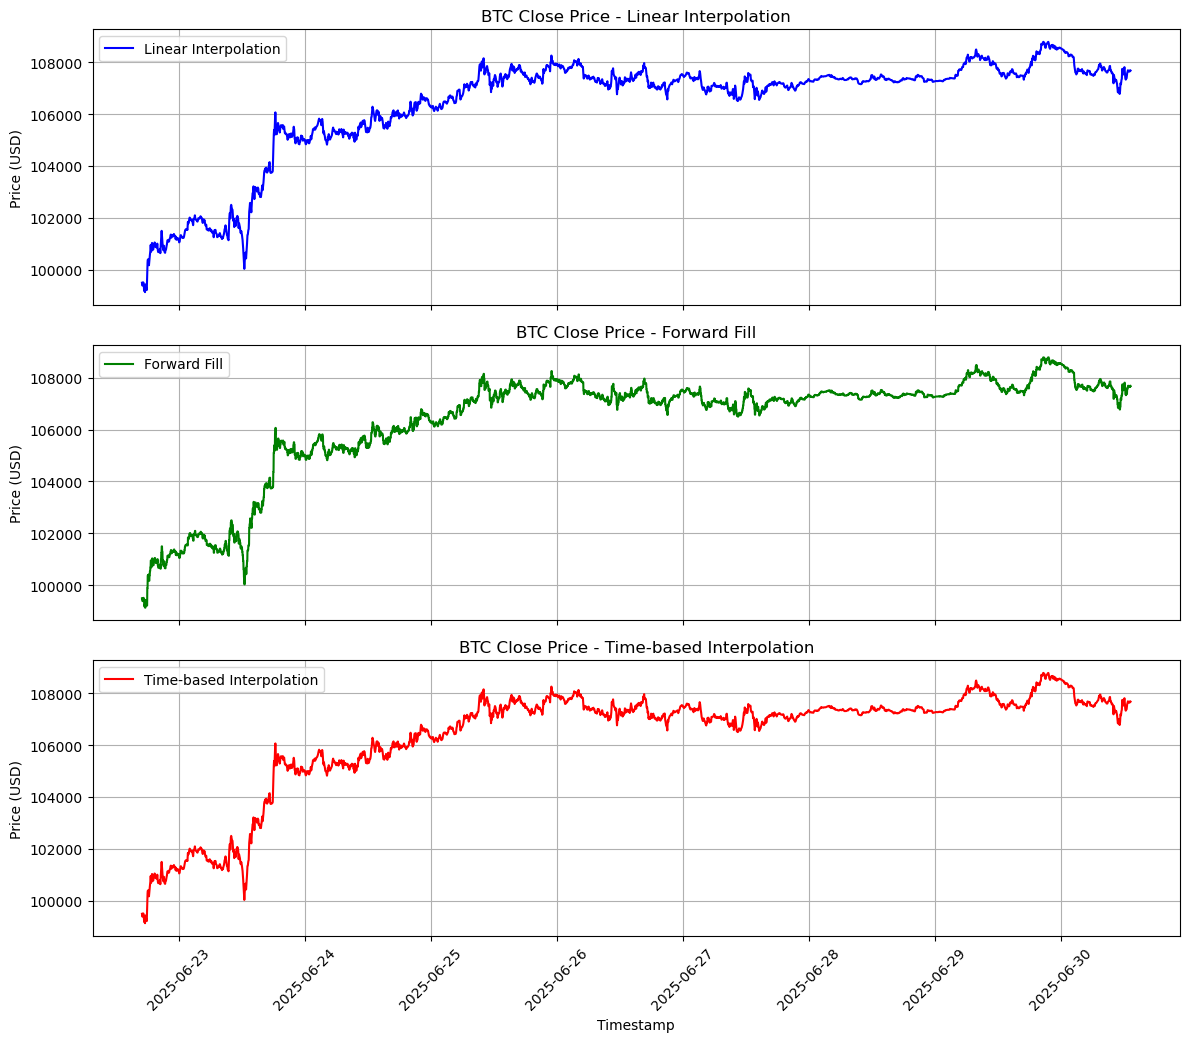

In [661]:
fig, (ax1, ax2, ax3) = plt.subplots(3, 1, figsize=(12, 10), sharex=True)

# Plot Linear Interpolation
ax1.plot(btc_df_linear.index, btc_df_linear['price'], label='Linear Interpolation', color='blue')
ax1.set_title('BTC Close Price - Linear Interpolation')
ax1.set_ylabel('Price (USD)')
ax1.legend()
ax1.grid(True)

# Plot Forward Fill
ax2.plot(btc_df_ffill.index, btc_df_ffill['price'], label='Forward Fill', color='green')
ax2.set_title('BTC Close Price - Forward Fill')
ax2.set_ylabel('Price (USD)')
ax2.legend()
ax2.grid(True)

# Plot Time-based Interpolation
ax3.plot(btc_df_time.index, btc_df_time['price'], label='Time-based Interpolation', color='red')
ax3.set_title('BTC Close Price - Time-based Interpolation')
ax3.set_xlabel('Timestamp')
ax3.set_ylabel('Price (USD)')
ax3.legend()
ax3.grid(True)

plt.tight_layout()
plt.xticks(rotation=45)
plt.show()

In [662]:
#merge data
data_df = pd.merge_asof(mstr_df.sort_values('timestamp'),btc_df_linear.sort_values('timestamp'),on='timestamp',direction='nearest',tolerance=pd.Timedelta('2min'),suffixes=('_mstr','_btc'))

In [663]:
#Handle missing data
data_df['price_mstr'] = data_df['price_mstr'].interpolate(method='linear').fillna(method='ffill')
data_df['price_btc'] = data_df['price_btc'].interpolate(method='linear').fillna(method='ffill')
data_df['volume'] = data_df['volume'].interpolate(method='linear').fillna(method='ffill')


C:\Users\mjree\AppData\Local\Temp\ipykernel_13144\3226462077.py:2: FutureWarning:

Series.fillna with 'method' is deprecated and will raise in a future version. Use obj.ffill() or obj.bfill() instead.

C:\Users\mjree\AppData\Local\Temp\ipykernel_13144\3226462077.py:3: FutureWarning:

Series.fillna with 'method' is deprecated and will raise in a future version. Use obj.ffill() or obj.bfill() instead.

C:\Users\mjree\AppData\Local\Temp\ipykernel_13144\3226462077.py:4: FutureWarning:

Series.fillna with 'method' is deprecated and will raise in a future version. Use obj.ffill() or obj.bfill() instead.



In [664]:
data_df = remove_outliers(data_df, 'price_mstr', 60, 3)
data_df = remove_outliers(data_df, 'price_btc', 60 ,3)
data_df = data_df.dropna()

In [665]:
data_df.to_sql('cleaned_data', engine, if_exists='replace', index=False)

2174

In [666]:
conn = sqlite3.connect('fourier_crypto_stock_data.db')
tables = pd.read_sql_query("SELECT name FROM sqlite_master WHERE type='table';",conn)
print("Tables:", tables['name'].tolist())

Tables: ['cleaned_data_5min', 'mstr', 'btc', 'cleaned_data']


In [667]:
cleaned_data = pd.read_sql_query("SELECT * FROM cleaned_data LIMIT 10;", conn)
display(cleaned_data)

timestamp  price_mstr    volume  price_btc
0  2025-06-23 09:30:00.000000    361.1600  152015.0   101131.0
1  2025-06-23 09:31:00.000000    359.3000  100031.0   101250.2
2  2025-06-23 09:32:00.000000    361.0000   65913.0   101369.4
3  2025-06-23 09:33:00.000000    362.8000   39771.0   101488.6
4  2025-06-23 09:34:00.000000    361.7800   23577.0   101607.8
5  2025-06-23 09:35:00.000000    363.7100   27197.0   101727.0
6  2025-06-23 09:36:00.000000    362.8900   35368.0   101798.2
7  2025-06-23 09:37:00.000000    363.0900   31803.0   101869.4
8  2025-06-23 09:38:00.000000    365.4401   53583.0   101940.6
9  2025-06-23 09:39:00.000000    366.1850   48787.0   102011.8

In [668]:
conn.close()

In [669]:
#Analyse relationship between MSTR and BTC
data_df['mstr_return'] = data_df['price_mstr'].pct_change()
data_df['btc_return'] = data_df['price_btc'].pct_change()

In [670]:
price_corr, _ = pearsonr(data_df['price_mstr'], data_df['price_btc'])
return_corr, _ = pearsonr(data_df['mstr_return'].dropna(), data_df['btc_return'].dropna())

In [671]:
print(f"Price Correlation: {price_corr:.3f}")
print(f"Return Correlation: {return_corr:.3f}")

Price Correlation: 0.883
Return Correlation: 0.406


In [672]:
#Linear Regression: MSTR price ~ BTC price
X = data_df[['price_btc']].values
y = data_df[['price_mstr']].values
model = LinearRegression().fit(X, y)
data_df['mstr_pred'] = model.predict(X)
# Extract the coefficient and intercept as scalar values before formatting
coefficient = float(model.coef_[0][0])  # Extract the scalar value from the array
intercept = float(model.intercept_[0])  # Extract the scalar value from the array

print(f"Regression: MSTR_price = {coefficient:.3f} * BTC_price + {intercept:.3f}")

Regression: MSTR_price = 0.004 * BTC_price + -66.370


In [673]:
fig = make_subplots(specs=[[{"secondary_y": True}]])
fig.add_trace(go.Scatter(x=data_df['timestamp'], y=data_df['price_mstr'], name='MSTR Price', line=dict(color='blue')),secondary_y=False)
fig.add_trace(go.Scatter(x=data_df['timestamp'], y=data_df['price_btc'], name='BTC Price', line=dict(color='orange')),secondary_y=True)

fig.update_layout(title='MSTR vs BTC Price Comparison', xaxis_title='Timestamp',yaxis_title='MSTR Price (USD)', yaxis2_title='BTC Price (USD)',template='plotly_dark')
fig.show()

The MSTR price peaks more relative to its price compare to BTC, however, the fluctuations in BTC are more significant due to the price. Both prices move similarly, suggesting a significant positive correlation between MSTR and BTC.

In [674]:
# Normalise prices (z-score standardisation)
data_df['price_mstr_norm'] = (data_df['price_mstr'] - data_df['price_mstr'].mean()) / data_df['price_mstr'].std()
data_df['price_btc_norm'] = (data_df['price_btc'] - data_df['price_btc'].mean()) / data_df['price_btc'].std()

In [675]:
# Correlation analysis
price_corr, _ = pearsonr(data_df['price_mstr'], data_df['price_btc'])
price_norm_corr, _ = pearsonr(data_df['price_mstr_norm'], data_df['price_btc_norm'])
return_corr, _ = pearsonr(data_df['mstr_return'].dropna(), data_df['btc_return'].dropna())

print(f"Raw Price Correlation: {price_corr:.3f}")
print(f"Normalized Price Correlation: {price_norm_corr:.3f}")
print(f"Return Correlation: {return_corr:.3f}")

Raw Price Correlation: 0.883
Normalized Price Correlation: 0.883
Return Correlation: 0.406


The price correlation is 0.883, suggesting that BTC and MSTR move together, which is expected due to the fact the MSTR's main asset is BTC. The return correlation is lower due to noise and intraday volatility, but the short-term co-movement is still strongly positively correlated at 0.406.


In [676]:
#Linear Regression: MSTR price ~ BTC price normalised
X_norm = data_df[['price_btc_norm']].values
y_norm = data_df[['price_mstr_norm']].values
model_norm = LinearRegression().fit(X_norm, y_norm)
data_df['mstr_pred_norm'] = model_norm.predict(X_norm)
# Extract the coefficient and intercept as scalar values before formatting
coefficient = float(model_norm.coef_[0][0])  # Extract the scalar value from the array
intercept = float(model_norm.intercept_[0])  # Extract the scalar value from the array

print(f"Regression: MSTR_price = {coefficient:.3f} * BTC_price + {intercept:.3f}")

Regression: MSTR_price = 0.883 * BTC_price + -0.000


In [677]:
fig = make_subplots(specs=[[{"secondary_y": True}]])
fig.add_trace(go.Scatter(x=data_df['timestamp'], y=data_df['price_mstr_norm'], name='MSTR Price (Norm)', line=dict(color='blue')),secondary_y=False)
fig.add_trace(go.Scatter(x=data_df['timestamp'], y=data_df['price_btc_norm'], name='BTC Price (Norm)', line=dict(color='orange')),secondary_y=True)
fig.update_layout(title='MSTR vs BTC Price Comparison (Norm)', xaxis_title='Timestamp',yaxis_title='MSTR Price (USD)', yaxis2_title='BTC Price (USD)',template='plotly_dark')
fig.show()

The prices of MSTR and BTC follow the same general movement. The normalised price of MSTR peaks higher than that of BTC, however, we can see that the MSTR price is heavily influenced by BTC.

In [678]:
#Volatility Analysis
data_df['mstr_volatility'] = data_df['price_mstr'].rolling(window=60).std()
avg_vol_mstr = data_df['mstr_volatility'].mean();
data_df['btc_volatility'] = data_df['price_btc'].rolling(window=60).std()
avg_vol_btc = data_df['btc_volatility'].mean();
btc_df_linear['volatility'] = btc_df_linear['price'].rolling(window=60).std()
btc_df_ffill['volatility'] = btc_df_ffill['price'].rolling(window=60).std()
btc_df_time['volatility'] = btc_df_time['price'].rolling(window=60).std()

print(f"MSTR Average Volatility: {avg_vol_mstr:.3f}")
print(f"BTC Average Volatility: {avg_vol_btc:.3f}")
print(f"BTC Linear Interpolation Volatility: {btc_df_linear['volatility'].mean():.3f}")
print(f"BTC Forward Fill Volatility: {btc_df_ffill['volatility'].mean():.3f}")
print(f"BTC Time Interpolation Volatility: {btc_df_time['volatility'].mean():.3f}")
vol_corr, _ = pearsonr(data_df['mstr_volatility'].dropna(), data_df['btc_volatility'].dropna())
print(f"Volatility Correlation: {vol_corr:.3f}")

MSTR Average Volatility: 1.379
BTC Average Volatility: 229.172
BTC Linear Interpolation Volatility: 104.810
BTC Forward Fill Volatility: 110.318
BTC Time Interpolation Volatility: 104.810
Volatility Correlation: 0.643


Truncating BTC data to the MSTR trading time reduces the accuracy of the volatility calculation for BTC, however linear interpolation seems to be a good method for filling missing prices, as there is negligable difference between the volatility calculation for each method.

Volatility Correlation of 0.643 indicates a moderately strong correlation between the risk profiles of MSTR and BTC, i.e. 64% of the time, a price change in BTC causes a price change in MSTR, although they are not perfectly in sync.
Other factors are influencing MSTR's volatility.

In [679]:
#Beta analysis
cov = data_df['mstr_return'].cov(data_df['btc_return'])
btc_var = data_df['btc_return'].var()
beta = cov / btc_var if btc_var != 0 else np.nan
print(f"MSTR Beta (relative to BTC): {beta:.3f}")

MSTR Beta (relative to BTC): 0.847


MSTR Beta = 0.847 indicated that a 1% change in BTC price leads to a 0.847% change in MSTR price in the same direction. This is lower than expected.

In [680]:
#Rolling correlation (60-minute window) - should reveal periods of stronger/weaker correlation
data_df['rolling_price_corr60'] = data_df['price_mstr'].rolling(window=60).corr(data_df['price_btc'])
data_df['rolling_return_corr60'] = data_df['mstr_return'].rolling(window=60).corr(data_df['btc_return'])
fig = go.Figure()
fig.add_trace(go.Scatter(x=data_df['timestamp'], y=data_df['rolling_price_corr60'], name='Rolling Price Correlation', line=dict(color='green')))
fig.add_trace(go.Scatter(x=data_df['timestamp'], y=data_df['rolling_return_corr60'], name='Rolling Return Correlation', line=dict(color='purple')))
fig.update_layout(title='Rolling Correlation (60-min window)', xaxis_title='Timestamp', yaxis_title='Correlation', template='plotly_dark')
fig.show()

In [681]:
#Rolling correlation (1-day window) - should reveal periods of stronger/weaker correlation
data_df['rolling_price_corr390'] = data_df['price_mstr'].rolling(window=390).corr(data_df['price_btc'])
data_df['rolling_return_corr390'] = data_df['mstr_return'].rolling(window=390).corr(data_df['btc_return'])
fig = go.Figure()
fig.add_trace(go.Scatter(x=data_df['timestamp'], y=data_df['rolling_price_corr390'], name='Rolling Price Correlation', line=dict(color='green')))
fig.add_trace(go.Scatter(x=data_df['timestamp'], y=data_df['rolling_return_corr390'], name='Rolling Return Correlation', line=dict(color='purple')))
fig.update_layout(title='Rolling Correlation (1-day window)', xaxis_title='Timestamp', yaxis_title='Correlation', template='plotly_dark')
fig.show()

The rolling correlation for a 1-day window (390 minutes for NASDAQ trading hours) shows significant movement in the correlation on different days, suggesting there are other factors affects the price movements.

In [682]:
# Rolling volatility (60-minute window)
data_df['mstr_volatility'] = data_df['mstr_return'].rolling(window=60).std() * np.sqrt(252 * 24 * 60)  # Annualized
data_df['btc_volatility'] = data_df['btc_return'].rolling(window=60).std() * np.sqrt(252 * 24 * 60)

# Plot volatility
fig = make_subplots(specs=[[{"secondary_y": True}]])
fig.add_trace(go.Scatter(x=data_df['timestamp'], y=data_df['mstr_volatility'], name='MSTR Volatility', line=dict(color='blue')), secondary_y=False)
fig.add_trace(go.Scatter(x=data_df['timestamp'], y=data_df['btc_volatility'], name='BTC Volatility', line=dict(color='orange')), secondary_y=True)
fig.update_layout(title='MSTR vs BTC Volatility (60-min window)', xaxis_title='Timestamp',yaxis_title='MSTR Volatility (Annualised)', yaxis2_title='BTC Volatility (Annualised)',template='plotly_dark')
fig.show()

The rolling volatility allows us to compare the volatility over time of MSTR vs BTC. For MSTR, there are significant fluctuations, with some peaks followed by drops. For BTC, we observe a more pronounced peak compared to MSTR.

The volatility of MSTR is generally lower than BTC's during the peak periods, but the start and end values are similar, suggesting that MSTR's volatility is influenced by BTC, but doesn't amplify the volatility as much during extreme peaks. The peaks are likely due to market events such as when MSTR purchases BTC.

MSTR generally shows higher volatility than BTC, suggesting a higher risk compared to BTC, despite the peaks in BTC.

In [683]:
# Spread: Actual MSTR price - Predicted MSTR price
data_df['spread'] = data_df['price_mstr'] - data_df['mstr_pred']

# Plot spread
fig = go.Figure()
fig.add_trace(go.Scatter(x=data_df['timestamp'], y=data_df['spread'], name='MSTR - Predicted Price', line=dict(color='red')))
fig.update_layout(title='MSTR Price Spread (Actual - Predicted)', xaxis_title='Timestamp',yaxis_title='Spread (USD)', template='plotly_dark')
fig.show()

The spread is near zero, suggesting that MSTR's price generally tracks its BTC-based prediction. However, there are significant deviations, indicating periods of market overreaction. This suggests that MSTR has a higher risk.

In [684]:
fig = go.Figure()
fig.add_trace(go.Scatter(x=data_df['timestamp'], y=data_df['volume'], name='MSTR - Volume', line=dict(color='green')))
fig.update_layout(title='MSTR Volume', xaxis_title='Timestamp',yaxis_title='Volume', template='plotly_dark')
fig.show()

The volume doesn't seem to give much insight into the spread fluctuatuons.

Lets instead downsample MSTR, to see if the results are consistent. This should avoid any potential smoothing from the linear interpolation of the upsampling of BTC data. (Note - This was a bad idea and the results are worse, not recommended)

In [685]:
#Downsample MSTR data to 5-minute intervals
mstr_df_down = mstr_df.set_index('timestamp').resample('5T').agg({'price': 'last','volume': 'sum'}).reset_index()
# Handle missing data
mstr_df_down['price'] = mstr_df_down['price'].interpolate(method='linear').fillna(method='ffill')
mstr_df_down['volume'] = mstr_df_down['volume'].interpolate(method='linear').fillna(method='ffill')

C:\Users\mjree\AppData\Local\Temp\ipykernel_13144\2635646212.py:2: FutureWarning:

'T' is deprecated and will be removed in a future version, please use 'min' instead.

C:\Users\mjree\AppData\Local\Temp\ipykernel_13144\2635646212.py:4: FutureWarning:

Series.fillna with 'method' is deprecated and will raise in a future version. Use obj.ffill() or obj.bfill() instead.

C:\Users\mjree\AppData\Local\Temp\ipykernel_13144\2635646212.py:5: FutureWarning:

Series.fillna with 'method' is deprecated and will raise in a future version. Use obj.ffill() or obj.bfill() instead.



In [686]:
# Merge with BTC data (5-minute)
down_data_df = pd.merge_asof(mstr_df_down.sort_values('timestamp'), btc_df.sort_values('timestamp'), on='timestamp',direction='nearest',tolerance=pd.Timedelta('1min'),suffixes=('_mstr', '_btc'))

In [687]:
# Handle remaining missing data
down_data_df['price_mstr'] = down_data_df['price_mstr'].interpolate(method='linear').fillna(method='ffill')
down_data_df['price_btc'] = down_data_df['price_btc'].interpolate(method='linear').fillna(method='ffill')
down_data_df['volume'] = down_data_df['volume'].interpolate(method='linear').fillna(method='ffill')

C:\Users\mjree\AppData\Local\Temp\ipykernel_13144\4221673050.py:2: FutureWarning:

Series.fillna with 'method' is deprecated and will raise in a future version. Use obj.ffill() or obj.bfill() instead.

C:\Users\mjree\AppData\Local\Temp\ipykernel_13144\4221673050.py:3: FutureWarning:

Series.fillna with 'method' is deprecated and will raise in a future version. Use obj.ffill() or obj.bfill() instead.

C:\Users\mjree\AppData\Local\Temp\ipykernel_13144\4221673050.py:4: FutureWarning:

Series.fillna with 'method' is deprecated and will raise in a future version. Use obj.ffill() or obj.bfill() instead.



In [688]:
down_data_df = remove_outliers(down_data_df, 'price_mstr', 12, 3)
down_data_df = remove_outliers(down_data_df, 'price_btc', 12, 3)
down_data_df = down_data_df.dropna()

In [689]:
down_data_df.to_sql('cleaned_data_5min', engine, if_exists='replace', index=False)

2061

In [690]:
# Calculate returns
down_data_df['mstr_return'] = down_data_df['price_mstr'].pct_change()
down_data_df['btc_return'] = down_data_df['price_btc'].pct_change()

In [691]:
# Correlation analysis
price_corr, _ = pearsonr(down_data_df['price_mstr'], down_data_df['price_btc'])
return_corr, _ = pearsonr(down_data_df['mstr_return'].dropna(), down_data_df['btc_return'].dropna())
print(f"Price Correlation: {price_corr:.3f}")
print(f"Return Correlation: {return_corr:.3f}")

Price Correlation: 0.832
Return Correlation: 0.324


In [692]:
# Volatility analysis
down_data_df['mstr_volatility'] = down_data_df['price_mstr'].rolling(window=12).std()  # 12 * 5min = 60min
down_data_df['btc_volatility'] = down_data_df['price_btc'].rolling(window=12).std()
vol_corr, _ = pearsonr(down_data_df['mstr_volatility'].dropna(), down_data_df['btc_volatility'].dropna())
print(f"\nMSTR Average Volatility: {down_data_df['mstr_volatility'].mean():.3f}")
print(f"BTC Average Volatility: {down_data_df['btc_volatility'].mean():.3f}")
print(f"Volatility Correlation: {vol_corr:.3f}")


MSTR Average Volatility: 0.307
BTC Average Volatility: 109.531
Volatility Correlation: 0.450


In [693]:
# Beta calculation
cov = down_data_df['mstr_return'].cov(down_data_df['btc_return'])
btc_var = down_data_df['btc_return'].var()
beta = cov / btc_var if btc_var != 0 else np.nan
print(f"MSTR Beta (relative to BTC): {beta:.3f}")

MSTR Beta (relative to BTC): 0.406


In [694]:
X = down_data_df[['price_btc']].values
y = down_data_df['price_mstr'].values
model = LinearRegression().fit(X, y)
down_data_df['mstr_pred_raw'] = model.predict(X)
print(f"\nRaw Regression: MSTR_price = {model.coef_[0]:.3f} * BTC_price + {model.intercept_:.3f}")


Raw Regression: MSTR_price = 0.004 * BTC_price + -76.627


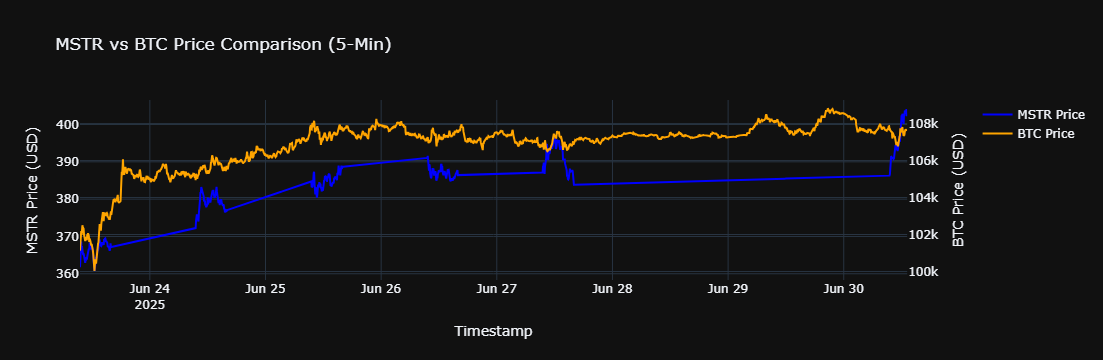

In [695]:
fig = make_subplots(specs=[[{"secondary_y": True}]])
fig.add_trace(go.Scatter(x=down_data_df['timestamp'], y=down_data_df['price_mstr'], name='MSTR Price', line=dict(color='blue')),secondary_y=False)
fig.add_trace(go.Scatter(x=down_data_df['timestamp'], y=down_data_df['price_btc'], name='BTC Price', line=dict(color='orange')),secondary_y=True)
fig.update_layout(title='MSTR vs BTC Price Comparison (5-Min)', xaxis_title='Timestamp',yaxis_title='MSTR Price (USD)', yaxis2_title='BTC Price (USD)',template='plotly_dark')
fig.show()